# UPDRS Score analysis

In [48]:
# Importing Python and external packages


import os
import sys
import importlib
from importlib import reload 
from dataclasses import dataclass, field, fields
from itertools import compress
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

import scipy
from scipy import stats
from scipy import signal
from scipy.signal import spectrogram, butter, filtfilt, freqz
from scipy.signal.windows import hann

import seaborn as sns
import pingouin as pg
from itertools import combinations
#from statannotations.Annotator import Annotator

import openpyxl
from openpyxl import Workbook, load_workbook
# import xlrd
import pickle
import json
import csv
import fooof
from fooof.plts.spectra import plot_spectrum

#mne
import mne
from mne.time_frequency import tfr_morlet 

# xdf
import pyxdf
import pyxdftools
from pyxdftools import XdfData

import datetime

In [178]:
jennifer_user_path = os.getcwd()
while jennifer_user_path[-14:] != 'jenniferbehnke':
    jennifer_user_path = os.path.dirname(jennifer_user_path)

# directory to this Repository
project_path = os.path.join(jennifer_user_path, 'code', 'Patterned_stimulation_project', 'patterned_DBS')
sys.path.append(project_path)

os.chdir(project_path)

# patterned DBS
import src.patterned_DBS.beta_suppression_latency.patterned_dbs_pilot as pilot
import src.patterned_DBS.beta_suppression_latency.patterned_find_dbs_OFF_moment as find_dbs_OFF_moment

# data processing
import src.patterned_DBS.data_processing.updrs_analysis as updrs_analysis

# utility functions
import src.patterned_DBS.utils.io as io
import src.patterned_DBS.utils.find_folders as find_folders
import src.patterned_DBS.utils.lfp_preprocessing as lfp_preprocessing
import src.patterned_DBS.utils.xdf_structure as xdf_structure

importlib.reload(pilot)
importlib.reload(find_dbs_OFF_moment)
importlib.reload(io)
importlib.reload(find_folders)
importlib.reload(lfp_preprocessing)
importlib.reload(xdf_structure)
importlib.reload(updrs_analysis)

<module 'src.patterned_DBS.data_processing.updrs_analysis' from '/Users/jenniferbehnke/code/Patterned_stimulation_project/patterned_DBS/src/patterned_DBS/data_processing/updrs_analysis.py'>

## Load UPDRS Scores

In [162]:
updrs = io.load_metadata_excel(
    sub="080",
    sheet_name="updrs",    
)

Excel file loaded successfully: metadata_080.xlsx 
loaded from: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Patterned_stimulation_project/data/sub-080


In [163]:
updrs.columns

Index(['Subject', 'Project_ID', 'Medication', 'Stimulation', 'UPDRS_done?',
       'BS_Streaming', 'Comments', 'Date (y-m-d)', 'UPDRS_III',
       'subscore_tremor_right', 'subscore_tremor_left',
       'subscore_tremor_total', 'subscore_rigidity_right',
       'subscore_rigidity_left', 'subscore_rigidity_total',
       'subscore_bradykinesia_right', 'subscore_bradykinesia_left',
       'subscore_bradykinesia_total', 'Speech', 'Facial expression',
       'Rigidity (head)', 'Rigidity (RUE)', 'Rigidity (LUE)', 'Rigidity (RLE)',
       'Rigidity (LLE)', 'Finger taps (RUE)', 'Finger taps (LUE)',
       'Hand movements (RUE)', 'Hand movements (LUE)',
       'Rapid alternating movements of hands (RUE)',
       'Rapid alternating movements of hands (LUE)', 'Foot taps (RLE)',
       'Foot taps (LLE)', 'Leg agility (RLE)', 'Leg agility (LLE)',
       'Arising from chair', 'Gait', 'Blockade during gait',
       'Postural stability', 'Posture', 'Body bradykinesia and hypokinesia',
       'Tremor 

In [164]:
updrs

,Subject,Project_ID,Medication,Stimulation,UPDRS_done?,BS_Streaming,Comments,Date (y-m-d),UPDRS_III,subscore_tremor_right,...,Tremor at rest (head),Tremor at rest (RUE),Tremor at rest (LUE),Tremor at rest (RLE),Tremor at rest (LLE),Postural tremor (RUE),Postural tremor (LUE),Action tremor (RUE),Action tremor (LUE),Consistency Rest Tremor
0,80,burst_dbs,on,StimOnA,YES,YES,NaN,2024-08-10,20,0,...,0,0,0,0,0,0,0,0,1,0
1,80,burst_dbs,on,StimOffA_run-1,YES,YES,NaN,2024-08-10,78,9,...,1,3,3,3,3,3,3,0,1,3
2,80,burst_dbs,on,StimOnB,YES,YES,NaN,2024-08-11,71,7,...,1,2,2,3,3,1,1,1,1,3


In [149]:
# Plot absolute updrs sub-scores
updrs_scores = updrs_analysis.load_updrsiii_scores(sub="084",
                                                   stimulation="continuous",
                                                   subscore="total")

Excel file loaded successfully: metadata_084.xlsx 
loaded from: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Patterned_stimulation_project/data/sub-084


In [150]:
updrs_scores[0]

'UPDRS_III'

In [151]:
updrs_scores[1]

,Subject,Project_ID,Medication,Stimulation,UPDRS_done?,BS_Streaming,Comments,Date (y-m-d),UPDRS_III,subscore_tremor_right,...,Tremor at rest (head),Tremor at rest (RUE),Tremor at rest (LUE),Tremor at rest (RLE),Tremor at rest (LLE),Postural tremor (RUE),Postural tremor (LUE),Action tremor (RUE),Action tremor (LUE),Consistency Rest Tremor
2,84,burst_dbs,on,StimOnA,YES,Yes,optimal condition,2024-08-11,12,1,...,0,0,0,0,0,0,0,1,1,0
3,84,burst_dbs,on,StimOffA_run-1,YES,Yes,NaN,2024-08-11,39,1,...,0,0,0,0,0,0,0,1,1,0


## Plot UPDRS-III Scores

### LINEPLOT

Excel file loaded successfully: metadata_084.xlsx 
loaded from: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Patterned_stimulation_project/data/sub-084
Excel file loaded successfully: metadata_084.xlsx 
loaded from: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Patterned_stimulation_project/data/sub-084
Excel file loaded successfully: metadata_080.xlsx 
loaded from: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Patterned_stimulation_project/data/sub-080
Excel file loaded successfully: metadata_080.xlsx 
loaded from: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Patterned_stimulation_project/data/sub-080
Excel file loaded successfully: metadata_075.xlsx 
loaded from: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Patterned_stimulation_project/data/sub-075
Excel file loaded successfully: metadata_075.xlsx 
loaded from: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Patterned_stimulation_project/data/sub-075
Excel file loaded successfully: metadata_086.x

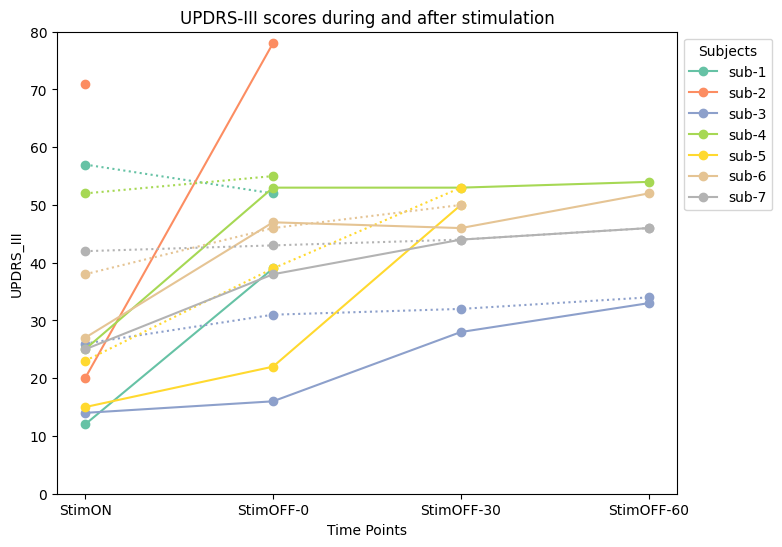

In [180]:
plot = updrs_analysis.lineplot_absolute_updrsiii(
    sub_list=["084", "080", "075", "086", "087", "088", "089"],
    subscore="total",
)

#sub_list=["084", "080", "075", "086", "087", "088", "089"],

### LINEPLOT Relative to StimOnA

Excel file loaded successfully: metadata_084.xlsx 
loaded from: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Patterned_stimulation_project/data/sub-084
Excel file loaded successfully: metadata_084.xlsx 
loaded from: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Patterned_stimulation_project/data/sub-084
Excel file loaded successfully: metadata_080.xlsx 
loaded from: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Patterned_stimulation_project/data/sub-080
Excel file loaded successfully: metadata_080.xlsx 
loaded from: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Patterned_stimulation_project/data/sub-080
Excel file loaded successfully: metadata_075.xlsx 
loaded from: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Patterned_stimulation_project/data/sub-075
Excel file loaded successfully: metadata_075.xlsx 
loaded from: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Patterned_stimulation_project/data/sub-075
Excel file loaded successfully: metadata_086.x

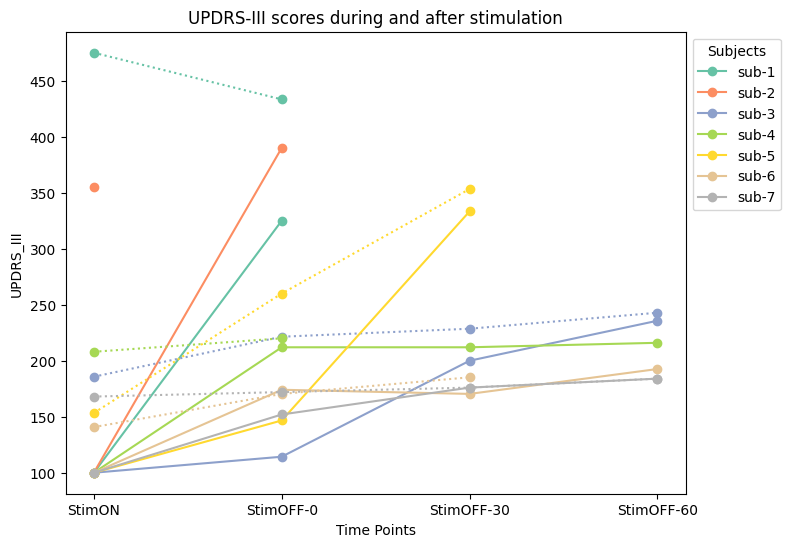

In [179]:
rel_lineplot = updrs_analysis.lineplot_normalized_to_StimOnA_updrsiii(
    sub_list=["084", "080", "075", "086", "087", "088", "089"],
    subscore="total",
)